In [43]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.tokenize import word_tokenize
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from flair.models import TextClassifier
from flair.data import Sentence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SpatialDropout1D
from keras import backend as K
from tensorflow.keras import models
from keras.layers import Bidirectional

In [2]:
def model_evaluation(real_v, pred_v):
    print(f"Accuracy sore: {accuracy_score(real_v, pred_v)}")
    print("Classification report:")
    print(classification_report(real_v, pred_v))
    cm = confusion_matrix(real_v, pred_v)
    print (f"Confusion matrix \n {cm}")



In [21]:
# Plot train/test loss and accuracy
def plotLoss(hist):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [9]:
# Find longest tweet in sequences
def max_tweet(sequences):
    max_length = len(sequences[0])
    for i in range(1, len(sequences)):
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [3]:
df = pd.read_csv("final_dataset.csv")
df.head()

,original_text,preprocessed_text,length_text,not_tag_text,airline,airline_sentiment,negative_reason
0,@VirginAmerica What @dhepburn said.,@mention @mention say,22,say,Virgin America,neutral,NaN
1,@VirginAmerica plus you've added commercials t...,@mention plus add commercial experience tacky,46,plus add commercial experience tacky,Virgin America,positive,NaN
2,@VirginAmerica I didn't today... Must mean I n...,@mention today must mean need take another trip,48,today must mean need take another trip,Virgin America,neutral,NaN
3,@VirginAmerica it's really aggressive to blast...,@mention really aggressive blast obnoxious ent...,88,really aggressive blast obnoxious entertainme...,Virgin America,negative,Bad Flight
4,@VirginAmerica and it's a really big bad thing...,@mention really big bad thing,30,really big bad thing,Virgin America,negative,Can't Tell


In [4]:
new_df = df[['airline_sentiment','preprocessed_text']].copy().dropna()

In [5]:
encoder = LabelEncoder()
X = new_df['preprocessed_text']
y = encoder.fit_transform(new_df["airline_sentiment"])

# Embedding Layer

Il livello di incorporamento è definito come il primo livello nascosto di una rete. Deve specificare 3 argomenti:

Deve specificare 3 argomenti:

<li> input_dim: questa è la dimensione del vocabolario nei dati di testo. Ad esempio, se i tuoi dati sono codificati in interi su valori compresi tra 0 e 10, la dimensione del vocabolario sarebbe di 11 parole.
<li> output_dim: questa è la dimensione dello spazio vettoriale in cui verranno incorporate le parole. Definisce la dimensione dei vettori di output da questo livello per ogni parola. Ad esempio, potrebbe essere 32 o 100 o anche più grande. Prova diversi valori per il tuo problema.
<li> input_length: questa è la lunghezza delle sequenze di input, come definiresti per qualsiasi livello di input di un modello Keras. Ad esempio, se tutti i tuoi documenti di input sono composti da 1000 parole, questo sarebbe 1000.

In [6]:
# Convert training data into tensors to feed into neural net
# create tokenizer
t = Tokenizer()
t.fit_on_texts(X)

### Troviamo input_dim

In [7]:
# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1
vocab_size

8845

In [8]:
# integer encode everything
sequences = t.texts_to_sequences(X)

In [10]:
tweet_num = max_tweet(sequences)
tweet_num

24

Le sequenze hanno lunghezze diverse e Keras preferisce che gli input siano vettorializzati e che tutti gli input abbiano la stessa lunghezza

In [11]:
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

Siamo ora pronti per definire il nostro livello di incorporamento come parte del nostro modello di rete neurale.

L'embedding ha un vocabolario di dimensione 8845 e una lunghezza di input di 24. 
Dobbiamo scegliere l'output_dim dell'embedding layer.

Il modello è un semplice modello di classificazione binaria. 
È importante sottolineare che l'output dal livello Embedding sarà di 24 vettori ciascuno di dimensione pari all'output_dim. 
Lo appiattiamo a un vettore a (scegliere dim) elementi per passare al livello di output Denso.

# LSTM CON EMBEDDING LAYER NO GLOVE

In [12]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size = 0.3, random_state = 0)

In [13]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100,input_length = tweet_num, trainable=False)

# MODELLO 1 (LSTM 64)

In [16]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_mod1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 100)           884500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 926,935
Trainable params: 42,435
Non-trainable params: 884,500
_________________________________________________________________


In [17]:
hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 45s - loss: 1.1044 - acc: 0.21 - ETA: 15s - loss: 1.0914 - acc: 0.43 - ETA: 9s - loss: 1.0766 - acc: 0.5063 - ETA: 7s - loss: 1.0630 - acc: 0.541 - ETA: 5s - loss: 1.0537 - acc: 0.552 - ETA: 5s - loss: 1.0487 - acc: 0.556 - ETA: 4s - loss: 1.0328 - acc: 0.572 - ETA: 4s - loss: 1.0177 - acc: 0.582 - ETA: 3s - loss: 1.0131 - acc: 0.585 - ETA: 3s - loss: 1.0087 - acc: 0.588 - ETA: 3s - loss: 1.0059 - acc: 0.589 - ETA: 2s - loss: 1.0014 - acc: 0.591 - ETA: 2s - loss: 0.9976 - acc: 0.593 - ETA: 2s - loss: 0.9919 - acc: 0.596 - ETA: 2s - loss: 0.9951 - acc: 0.592 - ETA: 2s - loss: 0.9923 - acc: 0.593 - ETA: 1s - loss: 0.9907 - acc: 0.593 - ETA: 1s - loss: 0.9859 - acc: 0.597 - ETA: 1s - loss: 0.9809 - acc: 0.600 - ETA: 1s - loss: 0.9767 - acc: 0.603 - ETA: 1s - loss: 0.9757 - acc: 0.602 - ETA: 1s - loss: 0.9735 - acc: 0.603 - ETA: 0s - loss: 0.9705 - acc: 0.605 - ETA: 0s - loss: 0.971

7173/7173 [==============================] - ETA: 1s - loss: 0.7962 - acc: 0.687 - ETA: 1s - loss: 0.7768 - acc: 0.713 - ETA: 1s - loss: 0.8284 - acc: 0.679 - ETA: 1s - loss: 0.8105 - acc: 0.675 - ETA: 1s - loss: 0.8158 - acc: 0.671 - ETA: 1s - loss: 0.8211 - acc: 0.666 - ETA: 1s - loss: 0.8220 - acc: 0.667 - ETA: 1s - loss: 0.8199 - acc: 0.670 - ETA: 1s - loss: 0.8172 - acc: 0.671 - ETA: 1s - loss: 0.8145 - acc: 0.675 - ETA: 1s - loss: 0.8125 - acc: 0.673 - ETA: 1s - loss: 0.8148 - acc: 0.674 - ETA: 1s - loss: 0.8168 - acc: 0.672 - ETA: 1s - loss: 0.8220 - acc: 0.670 - ETA: 1s - loss: 0.8194 - acc: 0.672 - ETA: 1s - loss: 0.8216 - acc: 0.671 - ETA: 0s - loss: 0.8205 - acc: 0.671 - ETA: 0s - loss: 0.8196 - acc: 0.671 - ETA: 0s - loss: 0.8190 - acc: 0.671 - ETA: 0s - loss: 0.8208 - acc: 0.669 - ETA: 0s - loss: 0.8238 - acc: 0.666 - ETA: 0s - loss: 0.8229 - acc: 0.666 - ETA: 0s - loss: 0.8201 - acc: 0.667 - ETA: 0s - loss: 0.8176 - acc: 0.668 - ETA: 0s - loss: 0.8179 - acc: 0.667 - ETA: 

7173/7173 [==============================] - ETA: 1s - loss: 0.7421 - acc: 0.734 - ETA: 2s - loss: 0.8030 - acc: 0.674 - ETA: 1s - loss: 0.8603 - acc: 0.637 - ETA: 2s - loss: 0.8651 - acc: 0.627 - ETA: 1s - loss: 0.8400 - acc: 0.634 - ETA: 1s - loss: 0.8226 - acc: 0.647 - ETA: 1s - loss: 0.8112 - acc: 0.656 - ETA: 1s - loss: 0.8136 - acc: 0.655 - ETA: 1s - loss: 0.8136 - acc: 0.657 - ETA: 1s - loss: 0.8083 - acc: 0.661 - ETA: 1s - loss: 0.8039 - acc: 0.663 - ETA: 1s - loss: 0.7982 - acc: 0.668 - ETA: 1s - loss: 0.7973 - acc: 0.668 - ETA: 1s - loss: 0.7961 - acc: 0.668 - ETA: 1s - loss: 0.7911 - acc: 0.672 - ETA: 1s - loss: 0.7896 - acc: 0.671 - ETA: 1s - loss: 0.7839 - acc: 0.675 - ETA: 1s - loss: 0.7811 - acc: 0.676 - ETA: 1s - loss: 0.7796 - acc: 0.678 - ETA: 1s - loss: 0.7758 - acc: 0.679 - ETA: 0s - loss: 0.7803 - acc: 0.676 - ETA: 0s - loss: 0.7808 - acc: 0.677 - ETA: 0s - loss: 0.7814 - acc: 0.675 - ETA: 0s - loss: 0.7792 - acc: 0.675 - ETA: 0s - loss: 0.7793 - acc: 0.675 - ETA: 

Epoch 31/40
7173/7173 [==============================] - ETA: 1s - loss: 0.8095 - acc: 0.648 - ETA: 1s - loss: 0.8002 - acc: 0.671 - ETA: 1s - loss: 0.8241 - acc: 0.656 - ETA: 1s - loss: 0.8142 - acc: 0.664 - ETA: 1s - loss: 0.7938 - acc: 0.675 - ETA: 1s - loss: 0.7937 - acc: 0.671 - ETA: 1s - loss: 0.7898 - acc: 0.674 - ETA: 1s - loss: 0.7776 - acc: 0.681 - ETA: 1s - loss: 0.7756 - acc: 0.679 - ETA: 1s - loss: 0.7696 - acc: 0.683 - ETA: 1s - loss: 0.7714 - acc: 0.682 - ETA: 1s - loss: 0.7707 - acc: 0.685 - ETA: 1s - loss: 0.7684 - acc: 0.688 - ETA: 1s - loss: 0.7655 - acc: 0.691 - ETA: 1s - loss: 0.7624 - acc: 0.693 - ETA: 0s - loss: 0.7636 - acc: 0.695 - ETA: 0s - loss: 0.7609 - acc: 0.695 - ETA: 0s - loss: 0.7638 - acc: 0.693 - ETA: 0s - loss: 0.7646 - acc: 0.693 - ETA: 0s - loss: 0.7671 - acc: 0.691 - ETA: 0s - loss: 0.7673 - acc: 0.691 - ETA: 0s - loss: 0.7669 - acc: 0.691 - ETA: 0s - loss: 0.7680 - acc: 0.690 - ETA: 0s - loss: 0.7692 - acc: 0.688 - ETA: 0s - loss: 0.7687 - acc: 0

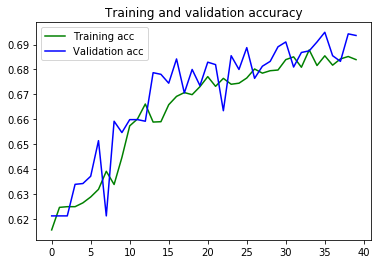

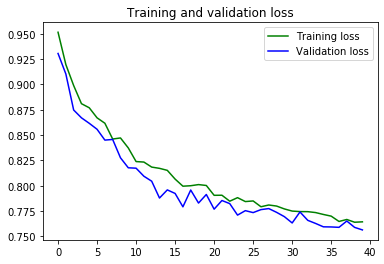

In [22]:
# Plot train/test loss and accuracy
plotLoss(hist_1)

In [23]:
# Find train and test f1
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6979
Testing Accuracy:  0.6844


In [24]:
y_pred = lstm_mod1.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.6844262295081968
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.91      0.80      2788
           1       0.44      0.26      0.33       919
           2       0.76      0.33      0.46       685

    accuracy                           0.68      4392
   macro avg       0.64      0.50      0.53      4392
weighted avg       0.66      0.68      0.65      4392

Confusion matrix 
 [[2540  219   29]
 [ 634  243   42]
 [ 368   94  223]]


# MODELLO 2 LSTM(32)

In [36]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(LSTM(32, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod2.add(Dense(3, activation='softmax'))
lstm_mod2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 901,623
Trainable params: 17,123
Non-trainable params: 884,500
_________________________________________________________________


In [37]:
hist_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 40s - loss: 1.0709 - acc: 0.71 - ETA: 10s - loss: 1.0644 - acc: 0.65 - ETA: 5s - loss: 1.0576 - acc: 0.6373 - ETA: 4s - loss: 1.0478 - acc: 0.633 - ETA: 3s - loss: 1.0390 - acc: 0.628 - ETA: 2s - loss: 1.0245 - acc: 0.632 - ETA: 2s - loss: 1.0162 - acc: 0.627 - ETA: 1s - loss: 1.0120 - acc: 0.625 - ETA: 1s - loss: 1.0085 - acc: 0.621 - ETA: 1s - loss: 0.9989 - acc: 0.624 - ETA: 1s - loss: 0.9915 - acc: 0.627 - ETA: 1s - loss: 0.9863 - acc: 0.627 - ETA: 1s - loss: 0.9878 - acc: 0.622 - ETA: 0s - loss: 0.9876 - acc: 0.620 - ETA: 0s - loss: 0.9852 - acc: 0.620 - ETA: 0s - loss: 0.9843 - acc: 0.619 - ETA: 0s - loss: 0.9824 - acc: 0.618 - ETA: 0s - loss: 0.9787 - acc: 0.619 - ETA: 0s - loss: 0.9754 - acc: 0.620 - ETA: 0s - loss: 0.9713 - acc: 0.623 - ETA: 0s - loss: 0.9699 - acc: 0.623 - ETA: 0s - loss: 0.9693 - acc: 0.622 - ETA: 0s - loss: 0.9649 - acc: 0.624 - 2s 347us/sample - los

7173/7173 [==============================] - ETA: 1s - loss: 0.8035 - acc: 0.640 - ETA: 1s - loss: 0.8169 - acc: 0.640 - ETA: 0s - loss: 0.8421 - acc: 0.621 - ETA: 0s - loss: 0.8373 - acc: 0.628 - ETA: 0s - loss: 0.8287 - acc: 0.639 - ETA: 0s - loss: 0.8379 - acc: 0.634 - ETA: 0s - loss: 0.8349 - acc: 0.634 - ETA: 0s - loss: 0.8394 - acc: 0.632 - ETA: 0s - loss: 0.8382 - acc: 0.634 - ETA: 0s - loss: 0.8349 - acc: 0.638 - ETA: 0s - loss: 0.8318 - acc: 0.639 - ETA: 0s - loss: 0.8235 - acc: 0.644 - ETA: 0s - loss: 0.8234 - acc: 0.646 - ETA: 0s - loss: 0.8253 - acc: 0.646 - ETA: 0s - loss: 0.8258 - acc: 0.645 - ETA: 0s - loss: 0.8258 - acc: 0.646 - ETA: 0s - loss: 0.8273 - acc: 0.646 - ETA: 0s - loss: 0.8273 - acc: 0.647 - ETA: 0s - loss: 0.8261 - acc: 0.647 - 1s 189us/sample - loss: 0.8256 - acc: 0.6477 - val_loss: 0.8162 - val_acc: 0.6527
Epoch 19/40
7173/7173 [==============================] - ETA: 1s - loss: 0.8436 - acc: 0.625 - ETA: 1s - loss: 0.8395 - acc: 0.627 - ETA: 1s - loss: 0.

7173/7173 [==============================] - ETA: 1s - loss: 0.8020 - acc: 0.656 - ETA: 1s - loss: 0.8125 - acc: 0.658 - ETA: 1s - loss: 0.8041 - acc: 0.662 - ETA: 1s - loss: 0.7777 - acc: 0.678 - ETA: 1s - loss: 0.7759 - acc: 0.680 - ETA: 0s - loss: 0.7803 - acc: 0.680 - ETA: 0s - loss: 0.7793 - acc: 0.679 - ETA: 0s - loss: 0.7836 - acc: 0.674 - ETA: 0s - loss: 0.7805 - acc: 0.676 - ETA: 0s - loss: 0.7771 - acc: 0.677 - ETA: 0s - loss: 0.7762 - acc: 0.676 - ETA: 0s - loss: 0.7738 - acc: 0.677 - ETA: 0s - loss: 0.7755 - acc: 0.678 - ETA: 0s - loss: 0.7724 - acc: 0.678 - ETA: 0s - loss: 0.7709 - acc: 0.678 - ETA: 0s - loss: 0.7717 - acc: 0.677 - ETA: 0s - loss: 0.7698 - acc: 0.679 - ETA: 0s - loss: 0.7740 - acc: 0.676 - ETA: 0s - loss: 0.7733 - acc: 0.676 - ETA: 0s - loss: 0.7751 - acc: 0.674 - 1s 195us/sample - loss: 0.7752 - acc: 0.6748 - val_loss: 0.7642 - val_acc: 0.6901
Epoch 37/40
7173/7173 [==============================] - ETA: 1s - loss: 0.8259 - acc: 0.601 - ETA: 1s - loss: 0.

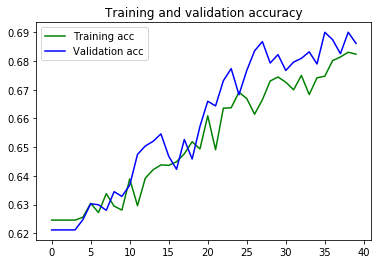

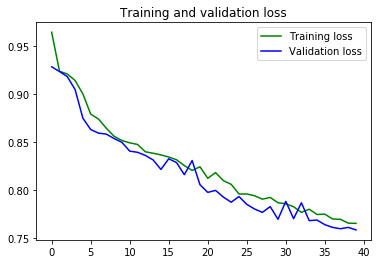

In [39]:
# Plot train/test loss and accuracy
plotLoss(hist_2)

In [40]:
# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6915
Testing Accuracy:  0.6767


In [42]:
y_pred = lstm_mod2.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.6766848816029144
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80      2788
           1       0.43      0.19      0.26       919
           2       0.75      0.28      0.41       685

    accuracy                           0.68      4392
   macro avg       0.63      0.47      0.49      4392
weighted avg       0.65      0.68      0.63      4392

Confusion matrix 
 [[2604  153   31]
 [ 713  174   32]
 [ 413   78  194]]


# MODELLO 3 CON SPATIAL DROPOUT1D

In [50]:
lst_mod3 = Sequential()
lst_mod3.add(embedding_layer)
lst_mod3.add(SpatialDropout1D(0.2))
lst_mod3.add(LSTM(32,
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lst_mod3.add(Dense(3, activation='softmax'))
lst_mod3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lst_mod3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 24, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 901,623
Trainable params: 17,123
Non-trainable params: 884,500
_________________________________________________________________


In [51]:
hist_3 = lst_mod3.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 46s - loss: 1.0671 - acc: 0.66 - ETA: 11s - loss: 1.0630 - acc: 0.61 - ETA: 6s - loss: 1.0471 - acc: 0.6317 - ETA: 4s - loss: 1.0332 - acc: 0.629 - ETA: 3s - loss: 1.0197 - acc: 0.628 - ETA: 2s - loss: 1.0100 - acc: 0.624 - ETA: 2s - loss: 1.0056 - acc: 0.617 - ETA: 1s - loss: 0.9984 - acc: 0.616 - ETA: 1s - loss: 0.9933 - acc: 0.616 - ETA: 1s - loss: 0.9853 - acc: 0.620 - ETA: 1s - loss: 0.9843 - acc: 0.618 - ETA: 1s - loss: 0.9838 - acc: 0.615 - ETA: 0s - loss: 0.9782 - acc: 0.617 - ETA: 0s - loss: 0.9741 - acc: 0.619 - ETA: 0s - loss: 0.9709 - acc: 0.620 - ETA: 0s - loss: 0.9689 - acc: 0.620 - ETA: 0s - loss: 0.9651 - acc: 0.621 - ETA: 0s - loss: 0.9610 - acc: 0.623 - ETA: 0s - loss: 0.9584 - acc: 0.624 - ETA: 0s - loss: 0.9568 - acc: 0.624 - 3s 356us/sample - loss: 0.9566 - acc: 0.6241 - val_loss: 0.9284 - val_acc: 0.6211
Epoch 2/40
7173/7173 [==============================]

7173/7173 [==============================] - ETA: 1s - loss: 0.8588 - acc: 0.601 - ETA: 1s - loss: 0.8489 - acc: 0.612 - ETA: 1s - loss: 0.8557 - acc: 0.615 - ETA: 1s - loss: 0.8535 - acc: 0.617 - ETA: 1s - loss: 0.8510 - acc: 0.621 - ETA: 1s - loss: 0.8607 - acc: 0.621 - ETA: 0s - loss: 0.8609 - acc: 0.621 - ETA: 0s - loss: 0.8605 - acc: 0.620 - ETA: 0s - loss: 0.8653 - acc: 0.619 - ETA: 0s - loss: 0.8573 - acc: 0.623 - ETA: 0s - loss: 0.8548 - acc: 0.626 - ETA: 0s - loss: 0.8573 - acc: 0.625 - ETA: 0s - loss: 0.8501 - acc: 0.629 - ETA: 0s - loss: 0.8483 - acc: 0.629 - ETA: 0s - loss: 0.8472 - acc: 0.629 - ETA: 0s - loss: 0.8482 - acc: 0.628 - ETA: 0s - loss: 0.8459 - acc: 0.631 - ETA: 0s - loss: 0.8441 - acc: 0.632 - ETA: 0s - loss: 0.8444 - acc: 0.632 - ETA: 0s - loss: 0.8433 - acc: 0.633 - 1s 202us/sample - loss: 0.8426 - acc: 0.6350 - val_loss: 0.8309 - val_acc: 0.6436
Epoch 18/40
7173/7173 [==============================] - ETA: 1s - loss: 0.7504 - acc: 0.703 - ETA: 1s - loss: 0.

7173/7173 [==============================] - ETA: 1s - loss: 0.6727 - acc: 0.726 - ETA: 1s - loss: 0.7844 - acc: 0.666 - ETA: 1s - loss: 0.7728 - acc: 0.674 - ETA: 1s - loss: 0.7795 - acc: 0.675 - ETA: 0s - loss: 0.8105 - acc: 0.660 - ETA: 0s - loss: 0.8154 - acc: 0.657 - ETA: 0s - loss: 0.8250 - acc: 0.651 - ETA: 0s - loss: 0.8301 - acc: 0.647 - ETA: 0s - loss: 0.8319 - acc: 0.647 - ETA: 0s - loss: 0.8274 - acc: 0.646 - ETA: 0s - loss: 0.8265 - acc: 0.649 - ETA: 0s - loss: 0.8239 - acc: 0.651 - ETA: 0s - loss: 0.8204 - acc: 0.654 - ETA: 0s - loss: 0.8183 - acc: 0.655 - ETA: 0s - loss: 0.8148 - acc: 0.657 - ETA: 0s - loss: 0.8138 - acc: 0.657 - ETA: 0s - loss: 0.8142 - acc: 0.656 - ETA: 0s - loss: 0.8139 - acc: 0.656 - ETA: 0s - loss: 0.8153 - acc: 0.656 - ETA: 0s - loss: 0.8145 - acc: 0.657 - ETA: 0s - loss: 0.8144 - acc: 0.656 - 1s 208us/sample - loss: 0.8142 - acc: 0.6566 - val_loss: 0.7995 - val_acc: 0.6657
Epoch 36/40
7173/7173 [==============================] - ETA: 1s - loss: 0.

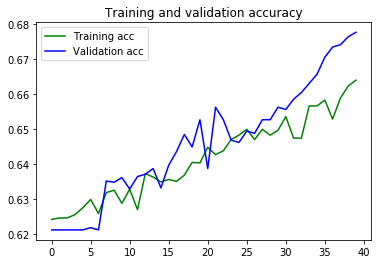

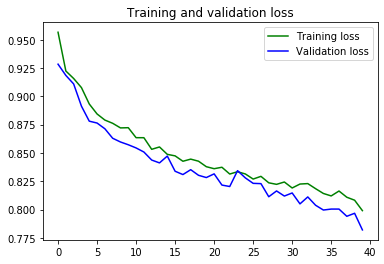

In [52]:
# Plot train/test loss and accuracy
plotLoss(hist_3)

In [54]:
# Find train and test accuracy
loss, accuracy = lst_mod3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lst_mod3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6839
Testing Accuracy:  0.6760


In [56]:
y_pred = lst_mod3.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.6760018214936248
Classification report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.80      2788
           1       0.44      0.16      0.24       919
           2       0.72      0.29      0.42       685

    accuracy                           0.68      4392
   macro avg       0.62      0.46      0.48      4392
weighted avg       0.65      0.68      0.62      4392

Confusion matrix 
 [[2622  136   30]
 [ 726  147   46]
 [ 436   49  200]]


# MODELLO 4 (LSTM 128)

In [57]:
lstm_mod4 = Sequential()
lstm_mod4.add(embedding_layer)
lstm_mod4.add(LSTM(128, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod4.add(Dense(3, activation='softmax'))
lstm_mod4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lstm_mod4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 1,002,135
Trainable params: 117,635
Non-trainable params: 884,500
_________________________________________________________________


In [58]:
hist_4 = lstm_mod4.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 48s - loss: 1.0857 - acc: 0.62 - ETA: 25s - loss: 1.0763 - acc: 0.63 - ETA: 18s - loss: 1.0705 - acc: 0.62 - ETA: 14s - loss: 1.0601 - acc: 0.63 - ETA: 11s - loss: 1.0457 - acc: 0.64 - ETA: 10s - loss: 1.0381 - acc: 0.64 - ETA: 9s - loss: 1.0289 - acc: 0.6406 - ETA: 8s - loss: 1.0199 - acc: 0.637 - ETA: 7s - loss: 1.0160 - acc: 0.631 - ETA: 6s - loss: 1.0119 - acc: 0.629 - ETA: 6s - loss: 0.9902 - acc: 0.641 - ETA: 6s - loss: 0.9822 - acc: 0.643 - ETA: 5s - loss: 0.9726 - acc: 0.646 - ETA: 5s - loss: 0.9723 - acc: 0.644 - ETA: 5s - loss: 0.9760 - acc: 0.639 - ETA: 4s - loss: 0.9706 - acc: 0.641 - ETA: 4s - loss: 0.9716 - acc: 0.638 - ETA: 4s - loss: 0.9678 - acc: 0.638 - ETA: 4s - loss: 0.9660 - acc: 0.637 - ETA: 4s - loss: 0.9658 - acc: 0.635 - ETA: 3s - loss: 0.9652 - acc: 0.632 - ETA: 3s - loss: 0.9639 - acc: 0.632 - ETA: 3s - loss: 0.9632 - acc: 0.631 - ETA: 3s - loss: 0.964

7173/7173 [==============================] - ETA: 3s - loss: 0.8570 - acc: 0.617 - ETA: 3s - loss: 0.8053 - acc: 0.656 - ETA: 3s - loss: 0.8268 - acc: 0.643 - ETA: 3s - loss: 0.8273 - acc: 0.642 - ETA: 3s - loss: 0.8247 - acc: 0.640 - ETA: 3s - loss: 0.8298 - acc: 0.634 - ETA: 3s - loss: 0.8420 - acc: 0.630 - ETA: 3s - loss: 0.8491 - acc: 0.627 - ETA: 3s - loss: 0.8526 - acc: 0.620 - ETA: 3s - loss: 0.8477 - acc: 0.624 - ETA: 2s - loss: 0.8403 - acc: 0.628 - ETA: 2s - loss: 0.8344 - acc: 0.632 - ETA: 2s - loss: 0.8271 - acc: 0.637 - ETA: 2s - loss: 0.8366 - acc: 0.630 - ETA: 2s - loss: 0.8367 - acc: 0.633 - ETA: 2s - loss: 0.8432 - acc: 0.631 - ETA: 2s - loss: 0.8379 - acc: 0.634 - ETA: 2s - loss: 0.8387 - acc: 0.633 - ETA: 2s - loss: 0.8304 - acc: 0.640 - ETA: 2s - loss: 0.8246 - acc: 0.643 - ETA: 2s - loss: 0.8246 - acc: 0.644 - ETA: 2s - loss: 0.8243 - acc: 0.646 - ETA: 2s - loss: 0.8268 - acc: 0.644 - ETA: 2s - loss: 0.8270 - acc: 0.647 - ETA: 2s - loss: 0.8275 - acc: 0.648 - ETA: 

7173/7173 [==============================] - ETA: 3s - loss: 0.6749 - acc: 0.726 - ETA: 3s - loss: 0.7042 - acc: 0.707 - ETA: 3s - loss: 0.7203 - acc: 0.697 - ETA: 3s - loss: 0.7512 - acc: 0.685 - ETA: 3s - loss: 0.7719 - acc: 0.668 - ETA: 3s - loss: 0.7791 - acc: 0.674 - ETA: 3s - loss: 0.7939 - acc: 0.665 - ETA: 3s - loss: 0.7954 - acc: 0.657 - ETA: 3s - loss: 0.8007 - acc: 0.658 - ETA: 3s - loss: 0.8084 - acc: 0.656 - ETA: 3s - loss: 0.8093 - acc: 0.658 - ETA: 3s - loss: 0.8049 - acc: 0.660 - ETA: 3s - loss: 0.7959 - acc: 0.665 - ETA: 3s - loss: 0.7978 - acc: 0.665 - ETA: 3s - loss: 0.7934 - acc: 0.668 - ETA: 2s - loss: 0.8000 - acc: 0.665 - ETA: 2s - loss: 0.7987 - acc: 0.665 - ETA: 2s - loss: 0.8003 - acc: 0.663 - ETA: 2s - loss: 0.8042 - acc: 0.660 - ETA: 2s - loss: 0.8071 - acc: 0.658 - ETA: 2s - loss: 0.8091 - acc: 0.656 - ETA: 2s - loss: 0.8069 - acc: 0.658 - ETA: 2s - loss: 0.8057 - acc: 0.661 - ETA: 2s - loss: 0.8135 - acc: 0.657 - ETA: 2s - loss: 0.8105 - acc: 0.660 - ETA: 

7173/7173 [==============================] - ETA: 3s - loss: 0.8074 - acc: 0.664 - ETA: 3s - loss: 0.7752 - acc: 0.668 - ETA: 3s - loss: 0.7905 - acc: 0.669 - ETA: 3s - loss: 0.7778 - acc: 0.666 - ETA: 3s - loss: 0.7890 - acc: 0.660 - ETA: 3s - loss: 0.7814 - acc: 0.666 - ETA: 3s - loss: 0.7916 - acc: 0.659 - ETA: 3s - loss: 0.7988 - acc: 0.659 - ETA: 3s - loss: 0.7926 - acc: 0.666 - ETA: 3s - loss: 0.7824 - acc: 0.675 - ETA: 3s - loss: 0.7786 - acc: 0.676 - ETA: 2s - loss: 0.7735 - acc: 0.681 - ETA: 2s - loss: 0.7805 - acc: 0.677 - ETA: 2s - loss: 0.7887 - acc: 0.673 - ETA: 2s - loss: 0.7936 - acc: 0.669 - ETA: 2s - loss: 0.7828 - acc: 0.674 - ETA: 2s - loss: 0.7865 - acc: 0.671 - ETA: 2s - loss: 0.7859 - acc: 0.673 - ETA: 2s - loss: 0.7830 - acc: 0.676 - ETA: 2s - loss: 0.7869 - acc: 0.674 - ETA: 2s - loss: 0.7880 - acc: 0.673 - ETA: 2s - loss: 0.7846 - acc: 0.675 - ETA: 2s - loss: 0.7852 - acc: 0.676 - ETA: 2s - loss: 0.7842 - acc: 0.677 - ETA: 2s - loss: 0.7828 - acc: 0.677 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.8093 - acc: 0.640 - ETA: 4s - loss: 0.8594 - acc: 0.625 - ETA: 3s - loss: 0.8555 - acc: 0.627 - ETA: 3s - loss: 0.8483 - acc: 0.632 - ETA: 3s - loss: 0.8330 - acc: 0.642 - ETA: 3s - loss: 0.8081 - acc: 0.664 - ETA: 3s - loss: 0.8061 - acc: 0.665 - ETA: 3s - loss: 0.8078 - acc: 0.659 - ETA: 3s - loss: 0.8148 - acc: 0.651 - ETA: 3s - loss: 0.8057 - acc: 0.657 - ETA: 3s - loss: 0.8052 - acc: 0.656 - ETA: 3s - loss: 0.8089 - acc: 0.654 - ETA: 3s - loss: 0.8064 - acc: 0.656 - ETA: 3s - loss: 0.8026 - acc: 0.659 - ETA: 2s - loss: 0.7940 - acc: 0.666 - ETA: 2s - loss: 0.7970 - acc: 0.663 - ETA: 2s - loss: 0.7948 - acc: 0.665 - ETA: 2s - loss: 0.7924 - acc: 0.667 - ETA: 2s - loss: 0.7950 - acc: 0.663 - ETA: 2s - loss: 0.7933 - acc: 0.664 - ETA: 2s - loss: 0.7907 - acc: 0.666 - ETA: 2s - loss: 0.7887 - acc: 0.669 - ETA: 2s - loss: 0.7897 - acc: 0.668 - ETA: 2s - loss: 0.7878 - acc: 0.669 - ETA: 2s - loss: 0.7854 - acc: 0.670 - ETA: 

7173/7173 [==============================] - ETA: 3s - loss: 0.7361 - acc: 0.679 - ETA: 3s - loss: 0.7544 - acc: 0.671 - ETA: 3s - loss: 0.7568 - acc: 0.664 - ETA: 3s - loss: 0.7567 - acc: 0.683 - ETA: 3s - loss: 0.7420 - acc: 0.695 - ETA: 3s - loss: 0.7252 - acc: 0.705 - ETA: 3s - loss: 0.7323 - acc: 0.702 - ETA: 3s - loss: 0.7473 - acc: 0.693 - ETA: 3s - loss: 0.7354 - acc: 0.699 - ETA: 3s - loss: 0.7500 - acc: 0.689 - ETA: 3s - loss: 0.7470 - acc: 0.694 - ETA: 3s - loss: 0.7480 - acc: 0.696 - ETA: 3s - loss: 0.7501 - acc: 0.697 - ETA: 3s - loss: 0.7442 - acc: 0.702 - ETA: 2s - loss: 0.7497 - acc: 0.698 - ETA: 2s - loss: 0.7457 - acc: 0.701 - ETA: 2s - loss: 0.7405 - acc: 0.702 - ETA: 2s - loss: 0.7430 - acc: 0.703 - ETA: 2s - loss: 0.7414 - acc: 0.701 - ETA: 2s - loss: 0.7433 - acc: 0.699 - ETA: 2s - loss: 0.7517 - acc: 0.694 - ETA: 2s - loss: 0.7586 - acc: 0.690 - ETA: 2s - loss: 0.7584 - acc: 0.689 - ETA: 2s - loss: 0.7641 - acc: 0.688 - ETA: 2s - loss: 0.7652 - acc: 0.686 - ETA: 

7173/7173 [==============================] - ETA: 3s - loss: 0.6795 - acc: 0.734 - ETA: 3s - loss: 0.7344 - acc: 0.687 - ETA: 3s - loss: 0.7624 - acc: 0.677 - ETA: 3s - loss: 0.7598 - acc: 0.681 - ETA: 3s - loss: 0.7663 - acc: 0.673 - ETA: 3s - loss: 0.7727 - acc: 0.664 - ETA: 3s - loss: 0.7863 - acc: 0.659 - ETA: 3s - loss: 0.7945 - acc: 0.658 - ETA: 3s - loss: 0.7951 - acc: 0.658 - ETA: 3s - loss: 0.7928 - acc: 0.658 - ETA: 3s - loss: 0.8025 - acc: 0.652 - ETA: 3s - loss: 0.7943 - acc: 0.655 - ETA: 3s - loss: 0.7927 - acc: 0.658 - ETA: 3s - loss: 0.7906 - acc: 0.660 - ETA: 2s - loss: 0.7898 - acc: 0.661 - ETA: 2s - loss: 0.7804 - acc: 0.667 - ETA: 2s - loss: 0.7790 - acc: 0.669 - ETA: 2s - loss: 0.7771 - acc: 0.671 - ETA: 2s - loss: 0.7771 - acc: 0.670 - ETA: 2s - loss: 0.7756 - acc: 0.670 - ETA: 2s - loss: 0.7778 - acc: 0.667 - ETA: 2s - loss: 0.7789 - acc: 0.667 - ETA: 2s - loss: 0.7802 - acc: 0.666 - ETA: 2s - loss: 0.7801 - acc: 0.667 - ETA: 2s - loss: 0.7797 - acc: 0.666 - ETA: 

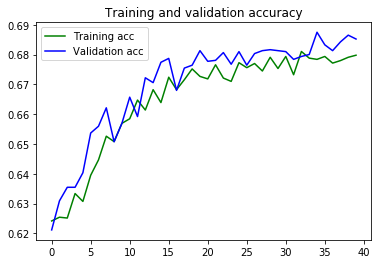

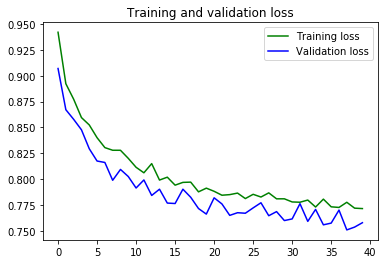

In [59]:
plotLoss(hist_4)

In [60]:
# Find train and test accuracy
loss, accuracy = lstm_mod4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6915
Testing Accuracy:  0.6787


In [61]:
y_pred = lstm_mod4.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.6787340619307832
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      2788
           1       0.42      0.31      0.36       919
           2       0.65      0.42      0.51       685

    accuracy                           0.68      4392
   macro avg       0.60      0.53      0.55      4392
weighted avg       0.66      0.68      0.66      4392

Confusion matrix 
 [[2405  295   88]
 [ 562  286   71]
 [ 287  108  290]]


# Using Pre-Trained GloVe Embedding

Caricare l'intero file di embedding di parole GloVe in memoria come un dizionario di array di parole da incorporare.

In [64]:
#dizionario pre-addestrato
embeddings_index = dict()
f = open('glove.6B\glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


Successivamente, dobbiamo creare una matrice di un embedding per ogni parola nel set di dati di train. Possiamo farlo enumerando tutte le parole univoche in Tokenizer.word_index e individuando il vettore del peso di incorporamento dall'incorporamento GloVe caricato.

Il risultato è una matrice di pesi solo per le parole che vedremo durante l'allenamento.

In [65]:
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

Ora possiamo definire il nostro modello, adattarlo e valutarlo come prima.

La differenza fondamentale è che lo strato di embedding può essere seminato con i pesi di embedding delle parole GloVe. Abbiamo scelto la versione a 100 dimensioni, quindi il livello di incorporamento deve essere definito con output_dim impostato a 100. Infine, non vogliamo aggiornare i pesi delle parole apprese in questo modello, quindi imposteremo l'attributo addestrabile per il modello su False .

In [66]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

# MODELLO 5 GLOVE+LSTM 32

In [67]:
lstm_mod5 = Sequential()
lstm_mod5.add(embedding_layer)
lstm_mod5.add(LSTM(32, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod5.add(Dense(3, activation='softmax'))
lstm_mod5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lstm_mod5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 99        
Total params: 901,623
Trainable params: 17,123
Non-trainable params: 884,500
_________________________________________________________________


In [68]:
hist_5 = lstm_mod5.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 50s - loss: 1.1093 - acc: 0.21 - ETA: 12s - loss: 1.1018 - acc: 0.29 - ETA: 7s - loss: 1.0929 - acc: 0.4074 - ETA: 4s - loss: 1.0874 - acc: 0.457 - ETA: 3s - loss: 1.0788 - acc: 0.491 - ETA: 3s - loss: 1.0702 - acc: 0.512 - ETA: 2s - loss: 1.0606 - acc: 0.525 - ETA: 2s - loss: 1.0453 - acc: 0.541 - ETA: 1s - loss: 1.0298 - acc: 0.555 - ETA: 1s - loss: 1.0139 - acc: 0.565 - ETA: 1s - loss: 1.0014 - acc: 0.572 - ETA: 1s - loss: 0.9984 - acc: 0.573 - ETA: 0s - loss: 0.9886 - acc: 0.578 - ETA: 0s - loss: 0.9797 - acc: 0.581 - ETA: 0s - loss: 0.9699 - acc: 0.587 - ETA: 0s - loss: 0.9611 - acc: 0.592 - ETA: 0s - loss: 0.9569 - acc: 0.593 - ETA: 0s - loss: 0.9511 - acc: 0.595 - ETA: 0s - loss: 0.9469 - acc: 0.596 - 3s 368us/sample - loss: 0.9463 - acc: 0.5956 - val_loss: 0.8528 - val_acc: 0.6211
Epoch 2/40
7173/7173 [==============================] - ETA: 1s - loss: 0.7940 - acc: 0.664

7173/7173 [==============================] - ETA: 1s - loss: 0.6566 - acc: 0.742 - ETA: 1s - loss: 0.6245 - acc: 0.750 - ETA: 1s - loss: 0.6462 - acc: 0.731 - ETA: 0s - loss: 0.6470 - acc: 0.732 - ETA: 0s - loss: 0.6439 - acc: 0.730 - ETA: 0s - loss: 0.6434 - acc: 0.732 - ETA: 0s - loss: 0.6363 - acc: 0.738 - ETA: 0s - loss: 0.6340 - acc: 0.742 - ETA: 0s - loss: 0.6380 - acc: 0.736 - ETA: 0s - loss: 0.6330 - acc: 0.738 - ETA: 0s - loss: 0.6312 - acc: 0.740 - ETA: 0s - loss: 0.6336 - acc: 0.739 - ETA: 0s - loss: 0.6321 - acc: 0.739 - ETA: 0s - loss: 0.6344 - acc: 0.737 - ETA: 0s - loss: 0.6326 - acc: 0.738 - ETA: 0s - loss: 0.6319 - acc: 0.739 - ETA: 0s - loss: 0.6338 - acc: 0.739 - ETA: 0s - loss: 0.6346 - acc: 0.739 - ETA: 0s - loss: 0.6285 - acc: 0.742 - 1s 187us/sample - loss: 0.6282 - acc: 0.7417 - val_loss: 0.6065 - val_acc: 0.7512
Epoch 19/40
7173/7173 [==============================] - ETA: 1s - loss: 0.6999 - acc: 0.718 - ETA: 1s - loss: 0.6069 - acc: 0.753 - ETA: 0s - loss: 0.

7173/7173 [==============================] - ETA: 1s - loss: 0.4255 - acc: 0.851 - ETA: 1s - loss: 0.5395 - acc: 0.804 - ETA: 0s - loss: 0.5801 - acc: 0.773 - ETA: 0s - loss: 0.5763 - acc: 0.771 - ETA: 0s - loss: 0.5656 - acc: 0.772 - ETA: 0s - loss: 0.5626 - acc: 0.774 - ETA: 0s - loss: 0.5537 - acc: 0.778 - ETA: 0s - loss: 0.5637 - acc: 0.775 - ETA: 0s - loss: 0.5684 - acc: 0.771 - ETA: 0s - loss: 0.5711 - acc: 0.771 - ETA: 0s - loss: 0.5710 - acc: 0.770 - ETA: 0s - loss: 0.5692 - acc: 0.772 - ETA: 0s - loss: 0.5711 - acc: 0.771 - ETA: 0s - loss: 0.5702 - acc: 0.768 - ETA: 0s - loss: 0.5715 - acc: 0.768 - ETA: 0s - loss: 0.5683 - acc: 0.771 - ETA: 0s - loss: 0.5692 - acc: 0.770 - ETA: 0s - loss: 0.5667 - acc: 0.772 - ETA: 0s - loss: 0.5646 - acc: 0.772 - ETA: 0s - loss: 0.5636 - acc: 0.772 - 1s 196us/sample - loss: 0.5638 - acc: 0.7722 - val_loss: 0.5784 - val_acc: 0.7616
Epoch 37/40
7173/7173 [==============================] - ETA: 1s - loss: 0.5707 - acc: 0.734 - ETA: 1s - loss: 0.

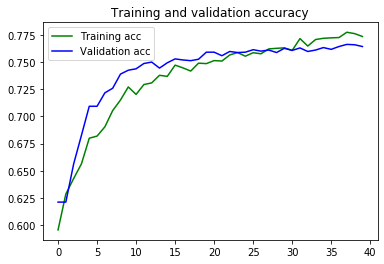

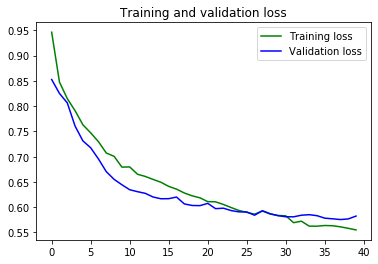

In [69]:
plotLoss(hist_5)

In [70]:
# Find train and test accuracy
loss, accuracy = lstm_mod5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7854
Testing Accuracy:  0.7632


In [71]:
y_pred = lstm_mod5.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.7632058287795993
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2788
           1       0.61      0.43      0.50       919
           2       0.73      0.60      0.66       685

    accuracy                           0.76      4392
   macro avg       0.71      0.65      0.67      4392
weighted avg       0.75      0.76      0.75      4392

Confusion matrix 
 [[2550  164   74]
 [ 449  391   79]
 [ 184   90  411]]


# MODELLO 6 GLOVE + LSTM 64

In [75]:
lstm_mod6 = Sequential()
lstm_mod6.add(embedding_layer)
lstm_mod6.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod6.add(Dense(3, activation='softmax'))
lstm_mod6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lstm_mod6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 926,935
Trainable params: 42,435
Non-trainable params: 884,500
_________________________________________________________________


In [76]:
hist_6= lstm_mod6.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 51s - loss: 1.1047 - acc: 0.29 - ETA: 17s - loss: 1.0966 - acc: 0.39 - ETA: 10s - loss: 1.0853 - acc: 0.47 - ETA: 7s - loss: 1.0733 - acc: 0.5112 - ETA: 6s - loss: 1.0600 - acc: 0.541 - ETA: 5s - loss: 1.0479 - acc: 0.557 - ETA: 4s - loss: 1.0318 - acc: 0.575 - ETA: 3s - loss: 1.0166 - acc: 0.582 - ETA: 3s - loss: 1.0030 - acc: 0.585 - ETA: 2s - loss: 0.9951 - acc: 0.585 - ETA: 2s - loss: 0.9780 - acc: 0.594 - ETA: 2s - loss: 0.9712 - acc: 0.595 - ETA: 2s - loss: 0.9621 - acc: 0.600 - ETA: 1s - loss: 0.9537 - acc: 0.603 - ETA: 1s - loss: 0.9532 - acc: 0.600 - ETA: 1s - loss: 0.9497 - acc: 0.601 - ETA: 1s - loss: 0.9469 - acc: 0.602 - ETA: 1s - loss: 0.9425 - acc: 0.603 - ETA: 1s - loss: 0.9398 - acc: 0.602 - ETA: 0s - loss: 0.9354 - acc: 0.604 - ETA: 0s - loss: 0.9338 - acc: 0.603 - ETA: 0s - loss: 0.9289 - acc: 0.605 - ETA: 0s - loss: 0.9254 - acc: 0.606 - ETA: 0s - loss: 0.919

7173/7173 [==============================] - ETA: 1s - loss: 0.5994 - acc: 0.765 - ETA: 1s - loss: 0.6132 - acc: 0.744 - ETA: 1s - loss: 0.6174 - acc: 0.745 - ETA: 1s - loss: 0.6327 - acc: 0.732 - ETA: 1s - loss: 0.6245 - acc: 0.739 - ETA: 1s - loss: 0.6341 - acc: 0.742 - ETA: 1s - loss: 0.6244 - acc: 0.751 - ETA: 1s - loss: 0.6197 - acc: 0.753 - ETA: 1s - loss: 0.6195 - acc: 0.757 - ETA: 1s - loss: 0.6240 - acc: 0.756 - ETA: 1s - loss: 0.6300 - acc: 0.752 - ETA: 1s - loss: 0.6289 - acc: 0.752 - ETA: 1s - loss: 0.6278 - acc: 0.752 - ETA: 0s - loss: 0.6329 - acc: 0.750 - ETA: 0s - loss: 0.6324 - acc: 0.751 - ETA: 0s - loss: 0.6325 - acc: 0.750 - ETA: 0s - loss: 0.6335 - acc: 0.748 - ETA: 0s - loss: 0.6313 - acc: 0.749 - ETA: 0s - loss: 0.6297 - acc: 0.750 - ETA: 0s - loss: 0.6326 - acc: 0.748 - ETA: 0s - loss: 0.6376 - acc: 0.745 - ETA: 0s - loss: 0.6398 - acc: 0.744 - ETA: 0s - loss: 0.6404 - acc: 0.742 - ETA: 0s - loss: 0.6403 - acc: 0.742 - ETA: 0s - loss: 0.6397 - acc: 0.742 - ETA: 

7173/7173 [==============================] - ETA: 1s - loss: 0.6199 - acc: 0.742 - ETA: 1s - loss: 0.5667 - acc: 0.765 - ETA: 1s - loss: 0.5630 - acc: 0.773 - ETA: 1s - loss: 0.5889 - acc: 0.765 - ETA: 1s - loss: 0.5918 - acc: 0.763 - ETA: 1s - loss: 0.5769 - acc: 0.770 - ETA: 1s - loss: 0.5639 - acc: 0.775 - ETA: 1s - loss: 0.5691 - acc: 0.769 - ETA: 1s - loss: 0.5706 - acc: 0.767 - ETA: 1s - loss: 0.5667 - acc: 0.768 - ETA: 1s - loss: 0.5745 - acc: 0.764 - ETA: 1s - loss: 0.5713 - acc: 0.766 - ETA: 1s - loss: 0.5746 - acc: 0.766 - ETA: 0s - loss: 0.5792 - acc: 0.764 - ETA: 0s - loss: 0.5791 - acc: 0.764 - ETA: 0s - loss: 0.5741 - acc: 0.767 - ETA: 0s - loss: 0.5695 - acc: 0.769 - ETA: 0s - loss: 0.5691 - acc: 0.769 - ETA: 0s - loss: 0.5686 - acc: 0.769 - ETA: 0s - loss: 0.5691 - acc: 0.770 - ETA: 0s - loss: 0.5701 - acc: 0.770 - ETA: 0s - loss: 0.5759 - acc: 0.767 - ETA: 0s - loss: 0.5768 - acc: 0.767 - ETA: 0s - loss: 0.5780 - acc: 0.768 - ETA: 0s - loss: 0.5776 - acc: 0.766 - ETA: 

7173/7173 [==============================] - ETA: 1s - loss: 0.5499 - acc: 0.781 - ETA: 1s - loss: 0.5708 - acc: 0.765 - ETA: 1s - loss: 0.5467 - acc: 0.781 - ETA: 1s - loss: 0.5453 - acc: 0.782 - ETA: 1s - loss: 0.5454 - acc: 0.785 - ETA: 1s - loss: 0.5416 - acc: 0.788 - ETA: 1s - loss: 0.5341 - acc: 0.787 - ETA: 1s - loss: 0.5447 - acc: 0.782 - ETA: 1s - loss: 0.5454 - acc: 0.781 - ETA: 1s - loss: 0.5447 - acc: 0.781 - ETA: 1s - loss: 0.5401 - acc: 0.784 - ETA: 1s - loss: 0.5347 - acc: 0.783 - ETA: 1s - loss: 0.5378 - acc: 0.783 - ETA: 0s - loss: 0.5355 - acc: 0.784 - ETA: 0s - loss: 0.5323 - acc: 0.786 - ETA: 0s - loss: 0.5277 - acc: 0.788 - ETA: 0s - loss: 0.5275 - acc: 0.788 - ETA: 0s - loss: 0.5304 - acc: 0.787 - ETA: 0s - loss: 0.5269 - acc: 0.791 - ETA: 0s - loss: 0.5250 - acc: 0.791 - ETA: 0s - loss: 0.5239 - acc: 0.792 - ETA: 0s - loss: 0.5228 - acc: 0.791 - ETA: 0s - loss: 0.5235 - acc: 0.789 - ETA: 0s - loss: 0.5241 - acc: 0.788 - ETA: 0s - loss: 0.5260 - acc: 0.788 - ETA: 

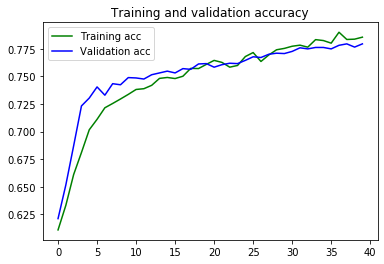

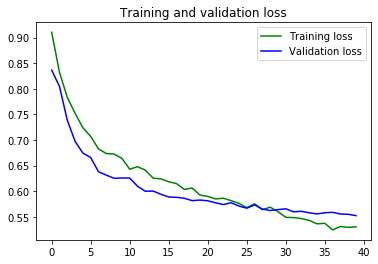

In [77]:
plotLoss(hist_6)

In [78]:
# Find train and test accuracy
loss, accuracy = lstm_mod6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8047
Testing Accuracy:  0.7684


In [79]:
y_pred = lstm_mod6.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.7684426229508197
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2788
           1       0.58      0.54      0.55       919
           2       0.73      0.66      0.69       685

    accuracy                           0.77      4392
   macro avg       0.71      0.69      0.70      4392
weighted avg       0.76      0.77      0.77      4392

Confusion matrix 
 [[2431  266   91]
 [ 347  492   80]
 [ 136   97  452]]


# MODELLO 7 CON 2 LSTM LAYER

In [80]:
lstm_mod7 = Sequential()
lstm_mod7.add(embedding_layer)
lstm_mod7.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
lstm_mod7.add(LSTM(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
lstm_mod7.add(Dense(3, activation='softmax'))
lstm_mod7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lstm_mod7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
lstm_16 (LSTM)               (None, 24, 256)           365568    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 387       
Total params: 1,447,575
Trainable params: 563,075
Non-trainable params: 884,500
_________________________________________________________________


In [81]:
hist_7 = lstm_mod7.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 1:50 - loss: 1.1085 - acc: 0.242 - ETA: 1:02 - loss: 1.0772 - acc: 0.418 - ETA: 47s - loss: 1.0498 - acc: 0.468 - ETA: 40s - loss: 1.0188 - acc: 0.50 - ETA: 35s - loss: 1.0047 - acc: 0.50 - ETA: 31s - loss: 0.9692 - acc: 0.53 - ETA: 28s - loss: 0.9573 - acc: 0.54 - ETA: 26s - loss: 0.9374 - acc: 0.55 - ETA: 25s - loss: 0.9261 - acc: 0.57 - ETA: 23s - loss: 0.9142 - acc: 0.57 - ETA: 22s - loss: 0.9025 - acc: 0.58 - ETA: 21s - loss: 0.9058 - acc: 0.58 - ETA: 20s - loss: 0.8996 - acc: 0.58 - ETA: 19s - loss: 0.8885 - acc: 0.59 - ETA: 18s - loss: 0.8800 - acc: 0.59 - ETA: 17s - loss: 0.8812 - acc: 0.59 - ETA: 17s - loss: 0.8864 - acc: 0.59 - ETA: 16s - loss: 0.8859 - acc: 0.59 - ETA: 16s - loss: 0.8820 - acc: 0.59 - ETA: 15s - loss: 0.8785 - acc: 0.59 - ETA: 14s - loss: 0.8781 - acc: 0.60 - ETA: 14s - loss: 0.8740 - acc: 0.60 - ETA: 13s - loss: 0.8736 - acc: 0.60 - ETA: 13s - loss: 

7173/7173 [==============================] - ETA: 19s - loss: 0.6025 - acc: 0.75 - ETA: 19s - loss: 0.5632 - acc: 0.76 - ETA: 19s - loss: 0.5905 - acc: 0.74 - ETA: 18s - loss: 0.6054 - acc: 0.73 - ETA: 18s - loss: 0.6314 - acc: 0.72 - ETA: 18s - loss: 0.6198 - acc: 0.72 - ETA: 18s - loss: 0.6311 - acc: 0.72 - ETA: 17s - loss: 0.6348 - acc: 0.72 - ETA: 17s - loss: 0.6411 - acc: 0.72 - ETA: 16s - loss: 0.6449 - acc: 0.72 - ETA: 16s - loss: 0.6414 - acc: 0.72 - ETA: 16s - loss: 0.6426 - acc: 0.73 - ETA: 15s - loss: 0.6466 - acc: 0.73 - ETA: 15s - loss: 0.6419 - acc: 0.72 - ETA: 15s - loss: 0.6442 - acc: 0.72 - ETA: 14s - loss: 0.6484 - acc: 0.72 - ETA: 14s - loss: 0.6530 - acc: 0.72 - ETA: 13s - loss: 0.6551 - acc: 0.72 - ETA: 13s - loss: 0.6514 - acc: 0.72 - ETA: 13s - loss: 0.6489 - acc: 0.72 - ETA: 12s - loss: 0.6468 - acc: 0.72 - ETA: 12s - loss: 0.6459 - acc: 0.73 - ETA: 12s - loss: 0.6444 - acc: 0.73 - ETA: 11s - loss: 0.6432 - acc: 0.73 - ETA: 11s - loss: 0.6444 - acc: 0.73 - ETA: 

7173/7173 [==============================] - ETA: 19s - loss: 0.6051 - acc: 0.73 - ETA: 19s - loss: 0.6326 - acc: 0.73 - ETA: 20s - loss: 0.5818 - acc: 0.75 - ETA: 19s - loss: 0.5722 - acc: 0.75 - ETA: 19s - loss: 0.5712 - acc: 0.76 - ETA: 19s - loss: 0.5717 - acc: 0.76 - ETA: 19s - loss: 0.5737 - acc: 0.76 - ETA: 18s - loss: 0.5878 - acc: 0.75 - ETA: 18s - loss: 0.5934 - acc: 0.75 - ETA: 17s - loss: 0.5892 - acc: 0.75 - ETA: 17s - loss: 0.5910 - acc: 0.74 - ETA: 16s - loss: 0.5859 - acc: 0.75 - ETA: 16s - loss: 0.5884 - acc: 0.74 - ETA: 16s - loss: 0.5864 - acc: 0.75 - ETA: 15s - loss: 0.5916 - acc: 0.75 - ETA: 15s - loss: 0.5977 - acc: 0.74 - ETA: 14s - loss: 0.5997 - acc: 0.74 - ETA: 14s - loss: 0.5984 - acc: 0.74 - ETA: 14s - loss: 0.5996 - acc: 0.74 - ETA: 13s - loss: 0.5929 - acc: 0.75 - ETA: 13s - loss: 0.5887 - acc: 0.75 - ETA: 12s - loss: 0.5876 - acc: 0.75 - ETA: 12s - loss: 0.5912 - acc: 0.75 - ETA: 12s - loss: 0.5956 - acc: 0.75 - ETA: 11s - loss: 0.5970 - acc: 0.75 - ETA: 

7173/7173 [==============================] - ETA: 19s - loss: 0.4820 - acc: 0.78 - ETA: 19s - loss: 0.5058 - acc: 0.78 - ETA: 19s - loss: 0.5016 - acc: 0.80 - ETA: 18s - loss: 0.5009 - acc: 0.80 - ETA: 18s - loss: 0.5080 - acc: 0.80 - ETA: 18s - loss: 0.5215 - acc: 0.79 - ETA: 17s - loss: 0.5416 - acc: 0.79 - ETA: 17s - loss: 0.5440 - acc: 0.79 - ETA: 17s - loss: 0.5552 - acc: 0.79 - ETA: 16s - loss: 0.5639 - acc: 0.78 - ETA: 16s - loss: 0.5611 - acc: 0.78 - ETA: 15s - loss: 0.5563 - acc: 0.78 - ETA: 15s - loss: 0.5565 - acc: 0.78 - ETA: 15s - loss: 0.5558 - acc: 0.78 - ETA: 14s - loss: 0.5488 - acc: 0.78 - ETA: 14s - loss: 0.5428 - acc: 0.79 - ETA: 14s - loss: 0.5400 - acc: 0.79 - ETA: 13s - loss: 0.5380 - acc: 0.79 - ETA: 13s - loss: 0.5364 - acc: 0.79 - ETA: 13s - loss: 0.5340 - acc: 0.79 - ETA: 12s - loss: 0.5437 - acc: 0.79 - ETA: 12s - loss: 0.5506 - acc: 0.78 - ETA: 12s - loss: 0.5521 - acc: 0.78 - ETA: 11s - loss: 0.5509 - acc: 0.78 - ETA: 11s - loss: 0.5483 - acc: 0.78 - ETA: 

7173/7173 [==============================] - ETA: 19s - loss: 0.5638 - acc: 0.77 - ETA: 19s - loss: 0.5481 - acc: 0.77 - ETA: 18s - loss: 0.5062 - acc: 0.80 - ETA: 18s - loss: 0.4797 - acc: 0.82 - ETA: 18s - loss: 0.4932 - acc: 0.81 - ETA: 18s - loss: 0.4916 - acc: 0.81 - ETA: 17s - loss: 0.4786 - acc: 0.81 - ETA: 17s - loss: 0.4825 - acc: 0.81 - ETA: 16s - loss: 0.4865 - acc: 0.81 - ETA: 16s - loss: 0.4903 - acc: 0.81 - ETA: 16s - loss: 0.4971 - acc: 0.80 - ETA: 15s - loss: 0.4894 - acc: 0.80 - ETA: 15s - loss: 0.4939 - acc: 0.80 - ETA: 15s - loss: 0.4928 - acc: 0.80 - ETA: 14s - loss: 0.4916 - acc: 0.80 - ETA: 14s - loss: 0.4991 - acc: 0.80 - ETA: 14s - loss: 0.4994 - acc: 0.80 - ETA: 13s - loss: 0.5059 - acc: 0.79 - ETA: 13s - loss: 0.5078 - acc: 0.79 - ETA: 13s - loss: 0.5013 - acc: 0.80 - ETA: 12s - loss: 0.5010 - acc: 0.80 - ETA: 12s - loss: 0.5038 - acc: 0.80 - ETA: 11s - loss: 0.5023 - acc: 0.80 - ETA: 11s - loss: 0.5012 - acc: 0.80 - ETA: 11s - loss: 0.5004 - acc: 0.80 - ETA: 

7173/7173 [==============================] - ETA: 19s - loss: 0.5804 - acc: 0.76 - ETA: 19s - loss: 0.4349 - acc: 0.81 - ETA: 19s - loss: 0.4400 - acc: 0.82 - ETA: 18s - loss: 0.4293 - acc: 0.82 - ETA: 18s - loss: 0.4576 - acc: 0.81 - ETA: 18s - loss: 0.4542 - acc: 0.82 - ETA: 17s - loss: 0.4669 - acc: 0.81 - ETA: 17s - loss: 0.4574 - acc: 0.81 - ETA: 17s - loss: 0.4498 - acc: 0.81 - ETA: 16s - loss: 0.4649 - acc: 0.81 - ETA: 16s - loss: 0.4666 - acc: 0.81 - ETA: 16s - loss: 0.4608 - acc: 0.81 - ETA: 15s - loss: 0.4614 - acc: 0.80 - ETA: 15s - loss: 0.4720 - acc: 0.80 - ETA: 15s - loss: 0.4819 - acc: 0.80 - ETA: 14s - loss: 0.4826 - acc: 0.80 - ETA: 14s - loss: 0.4764 - acc: 0.80 - ETA: 13s - loss: 0.4713 - acc: 0.80 - ETA: 13s - loss: 0.4665 - acc: 0.81 - ETA: 13s - loss: 0.4649 - acc: 0.81 - ETA: 12s - loss: 0.4625 - acc: 0.81 - ETA: 12s - loss: 0.4681 - acc: 0.81 - ETA: 12s - loss: 0.4652 - acc: 0.81 - ETA: 11s - loss: 0.4650 - acc: 0.81 - ETA: 11s - loss: 0.4631 - acc: 0.81 - ETA: 

7173/7173 [==============================] - ETA: 19s - loss: 0.3248 - acc: 0.85 - ETA: 19s - loss: 0.3966 - acc: 0.83 - ETA: 19s - loss: 0.3756 - acc: 0.84 - ETA: 18s - loss: 0.3866 - acc: 0.83 - ETA: 18s - loss: 0.3775 - acc: 0.84 - ETA: 18s - loss: 0.3887 - acc: 0.84 - ETA: 18s - loss: 0.3779 - acc: 0.85 - ETA: 17s - loss: 0.3724 - acc: 0.85 - ETA: 17s - loss: 0.3661 - acc: 0.85 - ETA: 17s - loss: 0.3649 - acc: 0.85 - ETA: 16s - loss: 0.3719 - acc: 0.85 - ETA: 16s - loss: 0.3756 - acc: 0.85 - ETA: 15s - loss: 0.3904 - acc: 0.85 - ETA: 15s - loss: 0.3860 - acc: 0.85 - ETA: 15s - loss: 0.3822 - acc: 0.85 - ETA: 14s - loss: 0.3879 - acc: 0.85 - ETA: 14s - loss: 0.3941 - acc: 0.85 - ETA: 14s - loss: 0.3952 - acc: 0.85 - ETA: 13s - loss: 0.3939 - acc: 0.85 - ETA: 13s - loss: 0.3963 - acc: 0.85 - ETA: 12s - loss: 0.3900 - acc: 0.85 - ETA: 12s - loss: 0.3915 - acc: 0.85 - ETA: 12s - loss: 0.3922 - acc: 0.85 - ETA: 11s - loss: 0.3902 - acc: 0.85 - ETA: 11s - loss: 0.3910 - acc: 0.85 - ETA: 

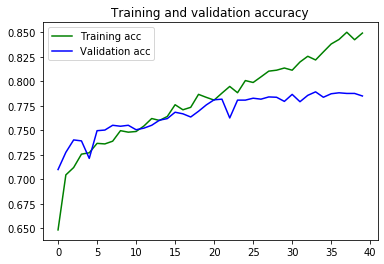

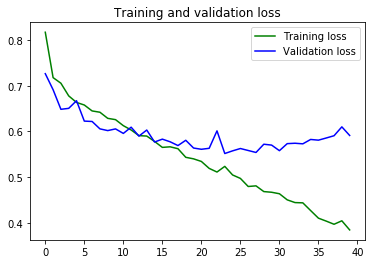

In [82]:
plotLoss(hist_7)

In [83]:
# Find train and test accuracy
loss, accuracy = lstm_mod7.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod7.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8588
Testing Accuracy:  0.7801


In [84]:
y_pred = lstm_mod7.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.7800546448087432
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      2788
           1       0.62      0.52      0.56       919
           2       0.71      0.68      0.70       685

    accuracy                           0.78      4392
   macro avg       0.72      0.70      0.71      4392
weighted avg       0.77      0.78      0.77      4392

Confusion matrix 
 [[2485  193  110]
 [ 366  474   79]
 [ 119   99  467]]


# MODELLO 8 CON 2 LSTM(64-32)

In [85]:
lstm_mod8 = Sequential()
lstm_mod8.add(embedding_layer)
lstm_mod8.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
lstm_mod8.add(LSTM(32,
                dropout = 0.2,
                recurrent_dropout = 0.5))
lstm_mod8.add(Dense(3, activation='softmax'))
lstm_mod8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lstm_mod8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
lstm_18 (LSTM)               (None, 24, 64)            42240     
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 99        
Total params: 939,255
Trainable params: 54,755
Non-trainable params: 884,500
_________________________________________________________________


In [86]:
hist_8 = lstm_mod8.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 1:36 - loss: 1.1107 - acc: 0.335 - ETA: 49s - loss: 1.0954 - acc: 0.390 - ETA: 33s - loss: 1.0866 - acc: 0.42 - ETA: 25s - loss: 1.0716 - acc: 0.49 - ETA: 20s - loss: 1.0611 - acc: 0.51 - ETA: 17s - loss: 1.0538 - acc: 0.52 - ETA: 15s - loss: 1.0389 - acc: 0.55 - ETA: 13s - loss: 1.0282 - acc: 0.55 - ETA: 12s - loss: 1.0202 - acc: 0.55 - ETA: 11s - loss: 1.0133 - acc: 0.56 - ETA: 10s - loss: 1.0024 - acc: 0.56 - ETA: 9s - loss: 0.9967 - acc: 0.5677 - ETA: 8s - loss: 0.9871 - acc: 0.575 - ETA: 8s - loss: 0.9820 - acc: 0.577 - ETA: 7s - loss: 0.9718 - acc: 0.584 - ETA: 7s - loss: 0.9608 - acc: 0.590 - ETA: 6s - loss: 0.9548 - acc: 0.592 - ETA: 6s - loss: 0.9573 - acc: 0.591 - ETA: 6s - loss: 0.9534 - acc: 0.592 - ETA: 5s - loss: 0.9522 - acc: 0.593 - ETA: 5s - loss: 0.9520 - acc: 0.593 - ETA: 5s - loss: 0.9477 - acc: 0.594 - ETA: 5s - loss: 0.9402 - acc: 0.598 - ETA: 4s - loss: 0.

7173/7173 [==============================] - ETA: 4s - loss: 0.6637 - acc: 0.718 - ETA: 4s - loss: 0.6229 - acc: 0.761 - ETA: 4s - loss: 0.6270 - acc: 0.757 - ETA: 4s - loss: 0.6575 - acc: 0.742 - ETA: 4s - loss: 0.6814 - acc: 0.721 - ETA: 4s - loss: 0.6741 - acc: 0.727 - ETA: 3s - loss: 0.6927 - acc: 0.723 - ETA: 3s - loss: 0.6769 - acc: 0.730 - ETA: 3s - loss: 0.6759 - acc: 0.727 - ETA: 3s - loss: 0.6809 - acc: 0.725 - ETA: 3s - loss: 0.6746 - acc: 0.730 - ETA: 3s - loss: 0.6848 - acc: 0.722 - ETA: 3s - loss: 0.6763 - acc: 0.728 - ETA: 3s - loss: 0.6773 - acc: 0.726 - ETA: 3s - loss: 0.6790 - acc: 0.724 - ETA: 3s - loss: 0.6801 - acc: 0.723 - ETA: 3s - loss: 0.6813 - acc: 0.722 - ETA: 3s - loss: 0.6809 - acc: 0.721 - ETA: 2s - loss: 0.6804 - acc: 0.723 - ETA: 2s - loss: 0.6847 - acc: 0.723 - ETA: 2s - loss: 0.6856 - acc: 0.723 - ETA: 2s - loss: 0.6870 - acc: 0.723 - ETA: 2s - loss: 0.6854 - acc: 0.725 - ETA: 2s - loss: 0.6866 - acc: 0.725 - ETA: 2s - loss: 0.6828 - acc: 0.728 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.6159 - acc: 0.773 - ETA: 4s - loss: 0.6357 - acc: 0.757 - ETA: 4s - loss: 0.6128 - acc: 0.760 - ETA: 4s - loss: 0.6143 - acc: 0.761 - ETA: 4s - loss: 0.6291 - acc: 0.751 - ETA: 4s - loss: 0.6548 - acc: 0.744 - ETA: 4s - loss: 0.6507 - acc: 0.747 - ETA: 3s - loss: 0.6388 - acc: 0.750 - ETA: 3s - loss: 0.6475 - acc: 0.741 - ETA: 3s - loss: 0.6559 - acc: 0.733 - ETA: 3s - loss: 0.6564 - acc: 0.732 - ETA: 3s - loss: 0.6666 - acc: 0.725 - ETA: 3s - loss: 0.6646 - acc: 0.726 - ETA: 3s - loss: 0.6605 - acc: 0.729 - ETA: 3s - loss: 0.6585 - acc: 0.730 - ETA: 3s - loss: 0.6647 - acc: 0.726 - ETA: 3s - loss: 0.6624 - acc: 0.728 - ETA: 3s - loss: 0.6548 - acc: 0.731 - ETA: 3s - loss: 0.6569 - acc: 0.732 - ETA: 3s - loss: 0.6556 - acc: 0.735 - ETA: 2s - loss: 0.6528 - acc: 0.737 - ETA: 2s - loss: 0.6528 - acc: 0.738 - ETA: 2s - loss: 0.6505 - acc: 0.739 - ETA: 2s - loss: 0.6472 - acc: 0.741 - ETA: 2s - loss: 0.6446 - acc: 0.742 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.5537 - acc: 0.765 - ETA: 4s - loss: 0.5553 - acc: 0.785 - ETA: 4s - loss: 0.5594 - acc: 0.783 - ETA: 4s - loss: 0.5562 - acc: 0.791 - ETA: 4s - loss: 0.5468 - acc: 0.796 - ETA: 4s - loss: 0.5558 - acc: 0.785 - ETA: 4s - loss: 0.5477 - acc: 0.787 - ETA: 3s - loss: 0.5588 - acc: 0.785 - ETA: 3s - loss: 0.5626 - acc: 0.776 - ETA: 3s - loss: 0.5699 - acc: 0.772 - ETA: 3s - loss: 0.5720 - acc: 0.770 - ETA: 3s - loss: 0.5764 - acc: 0.769 - ETA: 3s - loss: 0.5797 - acc: 0.766 - ETA: 3s - loss: 0.5795 - acc: 0.767 - ETA: 3s - loss: 0.5813 - acc: 0.767 - ETA: 3s - loss: 0.5810 - acc: 0.767 - ETA: 3s - loss: 0.5819 - acc: 0.768 - ETA: 3s - loss: 0.5782 - acc: 0.768 - ETA: 3s - loss: 0.5785 - acc: 0.770 - ETA: 3s - loss: 0.5802 - acc: 0.769 - ETA: 2s - loss: 0.5802 - acc: 0.769 - ETA: 2s - loss: 0.5788 - acc: 0.769 - ETA: 2s - loss: 0.5779 - acc: 0.769 - ETA: 2s - loss: 0.5784 - acc: 0.769 - ETA: 2s - loss: 0.5727 - acc: 0.773 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.6909 - acc: 0.773 - ETA: 4s - loss: 0.6506 - acc: 0.730 - ETA: 4s - loss: 0.6186 - acc: 0.750 - ETA: 4s - loss: 0.5766 - acc: 0.771 - ETA: 4s - loss: 0.6093 - acc: 0.753 - ETA: 4s - loss: 0.5961 - acc: 0.759 - ETA: 4s - loss: 0.5897 - acc: 0.758 - ETA: 3s - loss: 0.5946 - acc: 0.756 - ETA: 3s - loss: 0.5844 - acc: 0.760 - ETA: 3s - loss: 0.5732 - acc: 0.768 - ETA: 3s - loss: 0.5767 - acc: 0.766 - ETA: 3s - loss: 0.5768 - acc: 0.768 - ETA: 3s - loss: 0.5760 - acc: 0.769 - ETA: 3s - loss: 0.5715 - acc: 0.771 - ETA: 3s - loss: 0.5744 - acc: 0.769 - ETA: 3s - loss: 0.5703 - acc: 0.771 - ETA: 3s - loss: 0.5679 - acc: 0.772 - ETA: 3s - loss: 0.5656 - acc: 0.771 - ETA: 3s - loss: 0.5661 - acc: 0.771 - ETA: 2s - loss: 0.5656 - acc: 0.773 - ETA: 2s - loss: 0.5604 - acc: 0.775 - ETA: 2s - loss: 0.5589 - acc: 0.774 - ETA: 2s - loss: 0.5565 - acc: 0.776 - ETA: 2s - loss: 0.5604 - acc: 0.773 - ETA: 2s - loss: 0.5624 - acc: 0.772 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.5615 - acc: 0.765 - ETA: 4s - loss: 0.5024 - acc: 0.800 - ETA: 4s - loss: 0.5288 - acc: 0.789 - ETA: 4s - loss: 0.5418 - acc: 0.796 - ETA: 4s - loss: 0.5191 - acc: 0.798 - ETA: 4s - loss: 0.5231 - acc: 0.798 - ETA: 4s - loss: 0.5269 - acc: 0.798 - ETA: 3s - loss: 0.5145 - acc: 0.804 - ETA: 3s - loss: 0.5081 - acc: 0.808 - ETA: 3s - loss: 0.5134 - acc: 0.803 - ETA: 3s - loss: 0.5154 - acc: 0.801 - ETA: 3s - loss: 0.5137 - acc: 0.802 - ETA: 3s - loss: 0.5147 - acc: 0.800 - ETA: 3s - loss: 0.5074 - acc: 0.804 - ETA: 3s - loss: 0.5073 - acc: 0.803 - ETA: 3s - loss: 0.5066 - acc: 0.802 - ETA: 3s - loss: 0.5080 - acc: 0.798 - ETA: 3s - loss: 0.5089 - acc: 0.798 - ETA: 3s - loss: 0.5144 - acc: 0.795 - ETA: 2s - loss: 0.5147 - acc: 0.794 - ETA: 2s - loss: 0.5132 - acc: 0.794 - ETA: 2s - loss: 0.5139 - acc: 0.794 - ETA: 2s - loss: 0.5121 - acc: 0.795 - ETA: 2s - loss: 0.5139 - acc: 0.795 - ETA: 2s - loss: 0.5127 - acc: 0.796 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.4357 - acc: 0.867 - ETA: 4s - loss: 0.4531 - acc: 0.843 - ETA: 4s - loss: 0.4541 - acc: 0.841 - ETA: 4s - loss: 0.4832 - acc: 0.824 - ETA: 4s - loss: 0.4867 - acc: 0.812 - ETA: 4s - loss: 0.4844 - acc: 0.815 - ETA: 4s - loss: 0.5011 - acc: 0.801 - ETA: 4s - loss: 0.4992 - acc: 0.800 - ETA: 3s - loss: 0.5035 - acc: 0.799 - ETA: 3s - loss: 0.5090 - acc: 0.796 - ETA: 3s - loss: 0.5131 - acc: 0.799 - ETA: 3s - loss: 0.5115 - acc: 0.798 - ETA: 3s - loss: 0.5119 - acc: 0.798 - ETA: 3s - loss: 0.5117 - acc: 0.797 - ETA: 3s - loss: 0.5030 - acc: 0.801 - ETA: 3s - loss: 0.4974 - acc: 0.803 - ETA: 3s - loss: 0.4960 - acc: 0.803 - ETA: 3s - loss: 0.5018 - acc: 0.800 - ETA: 3s - loss: 0.5054 - acc: 0.800 - ETA: 2s - loss: 0.5009 - acc: 0.802 - ETA: 2s - loss: 0.4979 - acc: 0.802 - ETA: 2s - loss: 0.5018 - acc: 0.799 - ETA: 2s - loss: 0.5020 - acc: 0.799 - ETA: 2s - loss: 0.5067 - acc: 0.798 - ETA: 2s - loss: 0.5019 - acc: 0.800 - ETA: 

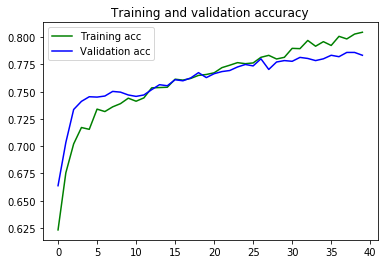

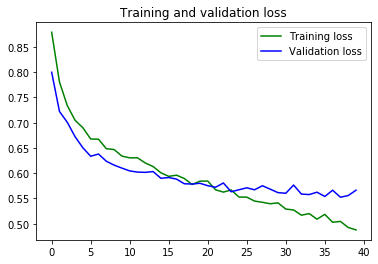

In [87]:
plotLoss(hist_8)

In [88]:
# Find train and test accuracy
loss, accuracy = lstm_mod8.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod8.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8159
Testing Accuracy:  0.7655


In [89]:
y_pred = lstm_mod8.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.7654826958105647
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      2788
           1       0.60      0.45      0.52       919
           2       0.74      0.59      0.66       685

    accuracy                           0.77      4392
   macro avg       0.72      0.65      0.68      4392
weighted avg       0.75      0.77      0.75      4392

Confusion matrix 
 [[2540  185   63]
 [ 424  417   78]
 [ 184   96  405]]


# MODELLO 9 (IL MIGLIORE TRA I PRECEDENTI 2 CON SPATIAL DROPOUT)

In [90]:
lstm_mod9 = Sequential()
lstm_mod9.add(embedding_layer)
lstm_mod9.add(SpatialDropout1D(0.2))
lstm_mod9.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
lstm_mod9.add(LSTM(32,
                dropout = 0.2,
                recurrent_dropout = 0.5))
lstm_mod9.add(Dense(3, activation='softmax'))
lstm_mod9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
lstm_mod9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           884500    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 24, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 24, 64)            42240     
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 99        
Total params: 939,255
Trainable params: 54,755
Non-trainable params: 884,500
_________________________________________________________________


In [91]:
hist_9 = lstm_mod9.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs=40, batch_size=128)

Train on 7173 samples, validate on 3075 samples
Epoch 1/40
7173/7173 [==============================] - ETA: 1:52 - loss: 1.0919 - acc: 0.390 - ETA: 57s - loss: 1.0895 - acc: 0.418 - ETA: 38s - loss: 1.0859 - acc: 0.41 - ETA: 29s - loss: 1.0815 - acc: 0.46 - ETA: 23s - loss: 1.0739 - acc: 0.49 - ETA: 20s - loss: 1.0674 - acc: 0.50 - ETA: 17s - loss: 1.0597 - acc: 0.51 - ETA: 15s - loss: 1.0504 - acc: 0.53 - ETA: 13s - loss: 1.0387 - acc: 0.54 - ETA: 12s - loss: 1.0260 - acc: 0.55 - ETA: 11s - loss: 1.0190 - acc: 0.56 - ETA: 10s - loss: 1.0085 - acc: 0.56 - ETA: 9s - loss: 0.9968 - acc: 0.5745 - ETA: 9s - loss: 0.9845 - acc: 0.582 - ETA: 8s - loss: 0.9764 - acc: 0.585 - ETA: 7s - loss: 0.9702 - acc: 0.587 - ETA: 7s - loss: 0.9607 - acc: 0.593 - ETA: 7s - loss: 0.9602 - acc: 0.593 - ETA: 6s - loss: 0.9560 - acc: 0.595 - ETA: 6s - loss: 0.9630 - acc: 0.592 - ETA: 5s - loss: 0.9550 - acc: 0.596 - ETA: 5s - loss: 0.9532 - acc: 0.598 - ETA: 5s - loss: 0.9543 - acc: 0.595 - ETA: 5s - loss: 0.

7173/7173 [==============================] - ETA: 4s - loss: 0.6723 - acc: 0.742 - ETA: 4s - loss: 0.6818 - acc: 0.738 - ETA: 4s - loss: 0.6949 - acc: 0.721 - ETA: 4s - loss: 0.7072 - acc: 0.709 - ETA: 4s - loss: 0.6712 - acc: 0.723 - ETA: 4s - loss: 0.6864 - acc: 0.721 - ETA: 3s - loss: 0.6887 - acc: 0.725 - ETA: 3s - loss: 0.6903 - acc: 0.721 - ETA: 3s - loss: 0.6912 - acc: 0.720 - ETA: 3s - loss: 0.7002 - acc: 0.717 - ETA: 3s - loss: 0.7010 - acc: 0.715 - ETA: 3s - loss: 0.7046 - acc: 0.714 - ETA: 3s - loss: 0.7101 - acc: 0.709 - ETA: 3s - loss: 0.7172 - acc: 0.708 - ETA: 3s - loss: 0.7202 - acc: 0.709 - ETA: 3s - loss: 0.7205 - acc: 0.707 - ETA: 3s - loss: 0.7152 - acc: 0.710 - ETA: 3s - loss: 0.7181 - acc: 0.706 - ETA: 3s - loss: 0.7207 - acc: 0.703 - ETA: 2s - loss: 0.7155 - acc: 0.709 - ETA: 2s - loss: 0.7138 - acc: 0.709 - ETA: 2s - loss: 0.7158 - acc: 0.709 - ETA: 2s - loss: 0.7132 - acc: 0.710 - ETA: 2s - loss: 0.7123 - acc: 0.710 - ETA: 2s - loss: 0.7104 - acc: 0.711 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.6356 - acc: 0.734 - ETA: 4s - loss: 0.6460 - acc: 0.742 - ETA: 4s - loss: 0.6491 - acc: 0.729 - ETA: 4s - loss: 0.6406 - acc: 0.736 - ETA: 3s - loss: 0.6627 - acc: 0.731 - ETA: 3s - loss: 0.6762 - acc: 0.725 - ETA: 3s - loss: 0.6663 - acc: 0.733 - ETA: 3s - loss: 0.6579 - acc: 0.732 - ETA: 3s - loss: 0.6600 - acc: 0.734 - ETA: 3s - loss: 0.6605 - acc: 0.736 - ETA: 3s - loss: 0.6514 - acc: 0.740 - ETA: 3s - loss: 0.6604 - acc: 0.738 - ETA: 3s - loss: 0.6659 - acc: 0.732 - ETA: 3s - loss: 0.6666 - acc: 0.729 - ETA: 3s - loss: 0.6680 - acc: 0.728 - ETA: 3s - loss: 0.6715 - acc: 0.726 - ETA: 3s - loss: 0.6706 - acc: 0.727 - ETA: 2s - loss: 0.6706 - acc: 0.727 - ETA: 2s - loss: 0.6697 - acc: 0.729 - ETA: 2s - loss: 0.6730 - acc: 0.728 - ETA: 2s - loss: 0.6727 - acc: 0.728 - ETA: 2s - loss: 0.6685 - acc: 0.731 - ETA: 2s - loss: 0.6678 - acc: 0.731 - ETA: 2s - loss: 0.6665 - acc: 0.732 - ETA: 2s - loss: 0.6645 - acc: 0.732 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.5657 - acc: 0.765 - ETA: 4s - loss: 0.6233 - acc: 0.742 - ETA: 4s - loss: 0.6309 - acc: 0.734 - ETA: 4s - loss: 0.6203 - acc: 0.732 - ETA: 3s - loss: 0.6340 - acc: 0.732 - ETA: 3s - loss: 0.6449 - acc: 0.725 - ETA: 3s - loss: 0.6547 - acc: 0.721 - ETA: 3s - loss: 0.6602 - acc: 0.719 - ETA: 3s - loss: 0.6537 - acc: 0.724 - ETA: 3s - loss: 0.6433 - acc: 0.730 - ETA: 3s - loss: 0.6449 - acc: 0.729 - ETA: 3s - loss: 0.6437 - acc: 0.733 - ETA: 3s - loss: 0.6437 - acc: 0.732 - ETA: 3s - loss: 0.6384 - acc: 0.734 - ETA: 3s - loss: 0.6334 - acc: 0.738 - ETA: 3s - loss: 0.6295 - acc: 0.739 - ETA: 3s - loss: 0.6275 - acc: 0.741 - ETA: 2s - loss: 0.6266 - acc: 0.742 - ETA: 2s - loss: 0.6278 - acc: 0.742 - ETA: 2s - loss: 0.6303 - acc: 0.741 - ETA: 2s - loss: 0.6264 - acc: 0.743 - ETA: 2s - loss: 0.6274 - acc: 0.744 - ETA: 2s - loss: 0.6247 - acc: 0.744 - ETA: 2s - loss: 0.6229 - acc: 0.745 - ETA: 2s - loss: 0.6221 - acc: 0.745 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.5806 - acc: 0.796 - ETA: 4s - loss: 0.5714 - acc: 0.785 - ETA: 3s - loss: 0.5751 - acc: 0.770 - ETA: 3s - loss: 0.5896 - acc: 0.763 - ETA: 3s - loss: 0.5735 - acc: 0.773 - ETA: 3s - loss: 0.5907 - acc: 0.755 - ETA: 3s - loss: 0.6001 - acc: 0.750 - ETA: 3s - loss: 0.6016 - acc: 0.752 - ETA: 3s - loss: 0.5994 - acc: 0.753 - ETA: 3s - loss: 0.5963 - acc: 0.751 - ETA: 3s - loss: 0.5940 - acc: 0.754 - ETA: 3s - loss: 0.5898 - acc: 0.759 - ETA: 3s - loss: 0.5903 - acc: 0.761 - ETA: 3s - loss: 0.5891 - acc: 0.760 - ETA: 3s - loss: 0.5883 - acc: 0.759 - ETA: 3s - loss: 0.5874 - acc: 0.760 - ETA: 2s - loss: 0.5930 - acc: 0.755 - ETA: 2s - loss: 0.5955 - acc: 0.754 - ETA: 2s - loss: 0.5938 - acc: 0.757 - ETA: 2s - loss: 0.5964 - acc: 0.756 - ETA: 2s - loss: 0.5981 - acc: 0.757 - ETA: 2s - loss: 0.5999 - acc: 0.757 - ETA: 2s - loss: 0.5966 - acc: 0.758 - ETA: 2s - loss: 0.5951 - acc: 0.758 - ETA: 2s - loss: 0.5963 - acc: 0.757 - ETA: 

7173/7173 [==============================] - ETA: 3s - loss: 0.6890 - acc: 0.671 - ETA: 3s - loss: 0.6020 - acc: 0.710 - ETA: 3s - loss: 0.5873 - acc: 0.731 - ETA: 3s - loss: 0.5906 - acc: 0.736 - ETA: 3s - loss: 0.5772 - acc: 0.748 - ETA: 3s - loss: 0.5779 - acc: 0.744 - ETA: 3s - loss: 0.5978 - acc: 0.736 - ETA: 3s - loss: 0.6120 - acc: 0.732 - ETA: 3s - loss: 0.6089 - acc: 0.736 - ETA: 3s - loss: 0.6029 - acc: 0.739 - ETA: 3s - loss: 0.5981 - acc: 0.740 - ETA: 3s - loss: 0.5939 - acc: 0.747 - ETA: 3s - loss: 0.5884 - acc: 0.751 - ETA: 3s - loss: 0.5878 - acc: 0.752 - ETA: 3s - loss: 0.5809 - acc: 0.758 - ETA: 3s - loss: 0.5823 - acc: 0.758 - ETA: 2s - loss: 0.5782 - acc: 0.759 - ETA: 2s - loss: 0.5851 - acc: 0.757 - ETA: 2s - loss: 0.5871 - acc: 0.757 - ETA: 2s - loss: 0.5854 - acc: 0.759 - ETA: 2s - loss: 0.5817 - acc: 0.762 - ETA: 2s - loss: 0.5828 - acc: 0.763 - ETA: 2s - loss: 0.5799 - acc: 0.762 - ETA: 2s - loss: 0.5784 - acc: 0.763 - ETA: 2s - loss: 0.5802 - acc: 0.764 - ETA: 

7173/7173 [==============================] - ETA: 4s - loss: 0.5588 - acc: 0.750 - ETA: 4s - loss: 0.4943 - acc: 0.796 - ETA: 4s - loss: 0.5347 - acc: 0.789 - ETA: 3s - loss: 0.5390 - acc: 0.793 - ETA: 3s - loss: 0.5311 - acc: 0.792 - ETA: 3s - loss: 0.5341 - acc: 0.787 - ETA: 3s - loss: 0.5270 - acc: 0.787 - ETA: 3s - loss: 0.5168 - acc: 0.794 - ETA: 3s - loss: 0.5245 - acc: 0.792 - ETA: 3s - loss: 0.5346 - acc: 0.789 - ETA: 3s - loss: 0.5377 - acc: 0.787 - ETA: 3s - loss: 0.5433 - acc: 0.781 - ETA: 3s - loss: 0.5542 - acc: 0.775 - ETA: 3s - loss: 0.5528 - acc: 0.776 - ETA: 3s - loss: 0.5526 - acc: 0.777 - ETA: 3s - loss: 0.5533 - acc: 0.776 - ETA: 3s - loss: 0.5567 - acc: 0.774 - ETA: 3s - loss: 0.5532 - acc: 0.776 - ETA: 3s - loss: 0.5529 - acc: 0.778 - ETA: 2s - loss: 0.5486 - acc: 0.780 - ETA: 2s - loss: 0.5511 - acc: 0.779 - ETA: 2s - loss: 0.5483 - acc: 0.781 - ETA: 2s - loss: 0.5480 - acc: 0.779 - ETA: 2s - loss: 0.5459 - acc: 0.780 - ETA: 2s - loss: 0.5460 - acc: 0.780 - ETA: 

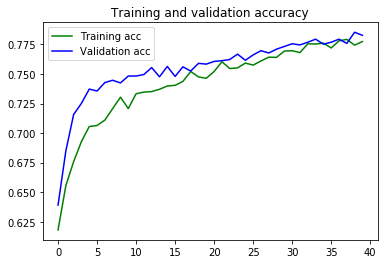

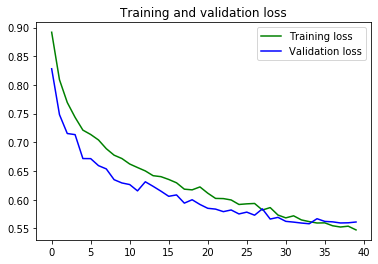

In [92]:
plotLoss(hist_9)

In [93]:
# Find train and test accuracy
loss, accuracy = lstm_mod9.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod9.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8036
Testing Accuracy:  0.7735


In [94]:
y_pred = lstm_mod9.predict_classes(X_test)
model_evaluation(y_test, y_pred)

Accuracy sore: 0.7734517304189436
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      2788
           1       0.63      0.45      0.53       919
           2       0.72      0.65      0.68       685

    accuracy                           0.77      4392
   macro avg       0.72      0.67      0.69      4392
weighted avg       0.76      0.77      0.76      4392

Confusion matrix 
 [[2540  163   85]
 [ 417  412   90]
 [ 165   75  445]]
